In [1]:
import numpy as np
from helper_functions import generate_SBM, logLik_general_SBM
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from scipy.stats import chi2

# If $K=3$

In [2]:
K0 = 3
n = 500
P_true = np.ones((K0, K0)) * 0.03 + np.eye(K0) * 0.15
n_true = np.array([round(n / K0)] * K0)
n_true[-1] = n - n_true[:-1].sum()

In [3]:
network = [generate_SBM(P_true=P_true, n_true=n_true, seed=i) for i in tqdm(range(200))]

100%|██████████| 200/200 [00:03<00:00, 58.40it/s]


100%|██████████| 200/200 [00:00<00:00, 232.88it/s]


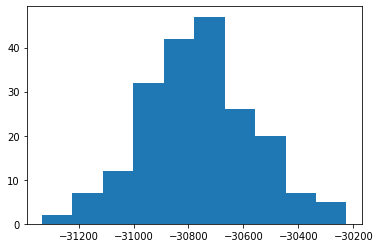

In [4]:
logLik_true = np.array([logLik_general_SBM(A=A, K=K0, labels=[list(range(n_true[:j].sum(), n_true[:(j+1)].sum())) for j in range(K0)], P=P_true)['logLik'] for A in tqdm(network)])
plt.hist(logLik_true)
plt.show()

In [5]:
def max_likelihood_estimator_kmeans(A: sparse.csr_matrix, K: int = 2):
    eig_A = eigsh(A.asfptype(), k = K, which ='LA')
    kmeans_d = KMeans(n_clusters=K, random_state=0).fit(eig_A[1][:,-K:])
    return logLik_general_SBM(K=K, A=A, labels=[np.where(kmeans_d.labels_==i)[0] for i in range(K)])['logLik']

## Underfit $K'=K-1$

100%|██████████| 200/200 [00:06<00:00, 32.37it/s]


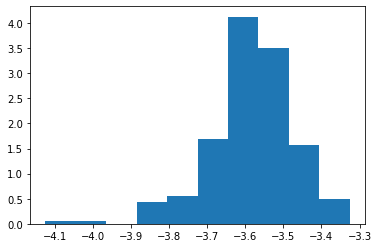

In [6]:
logLik_underfit = np.array([max_likelihood_estimator_kmeans(A, K0-1) for A in tqdm(network)])
plt.hist((logLik_underfit - logLik_true)/ n, density = True)
plt.show()

Why does it look different from the plot in Hu's paper?

## Correct $K' = K$

100%|██████████| 200/200 [00:10<00:00, 19.55it/s]


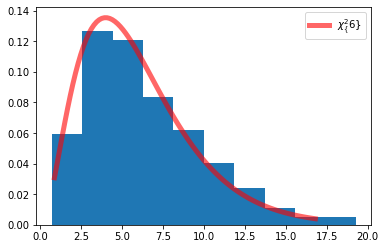

In [7]:
logLik_correct_K = np.array([max_likelihood_estimator_kmeans(A, K0) for A in tqdm(network)])
plt.hist((logLik_correct_K - logLik_true) * 2, density = True)
df = int(K0 * (K0+1) / 2)
x = np.linspace(chi2.ppf(0.01, df),
                chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=r'$\chi^2_\{' + str(df) +  r'\}$')
plt.legend()
plt.show()

This looks similar, and should be $\chi^2_6$

## Overfit $K'= K+1$

100%|██████████| 200/200 [00:23<00:00,  8.51it/s]


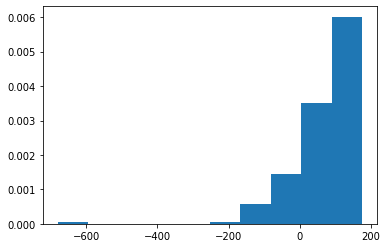

In [8]:
logLik_overfit = np.array([max_likelihood_estimator_kmeans(A, K0+1) for A in tqdm(network)])
plt.hist((logLik_overfit - logLik_true) * 2, density = True)
plt.show()

This also looks similar. 

Now I understand why they say the overfit case is infeasible.

## Look at how this distribution grows with $n$

100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


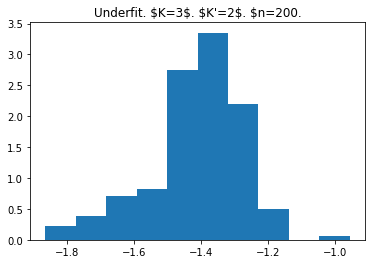

100%|██████████| 200/200 [00:15<00:00, 12.86it/s]


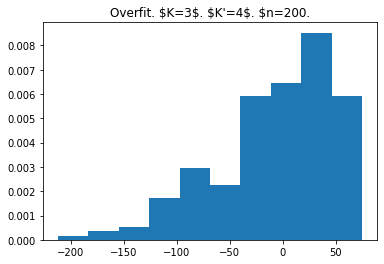

100%|██████████| 200/200 [00:07<00:00, 26.70it/s]


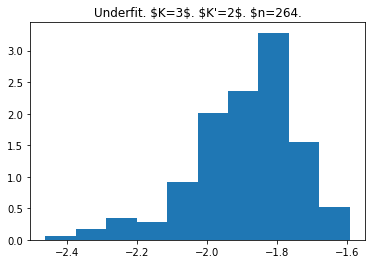

100%|██████████| 200/200 [00:16<00:00, 12.02it/s]


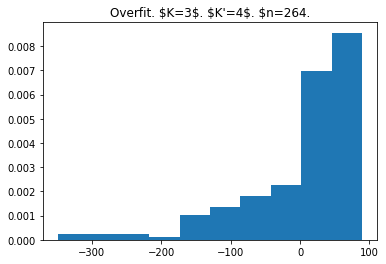

100%|██████████| 200/200 [00:08<00:00, 23.90it/s]


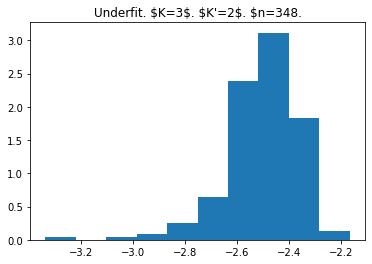

100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


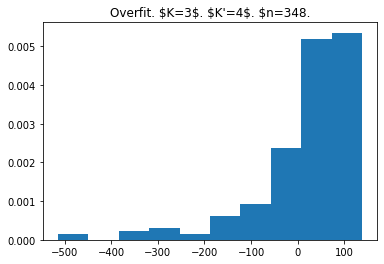

100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


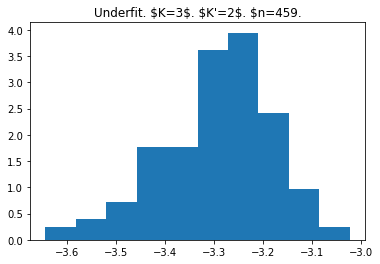

100%|██████████| 200/200 [00:20<00:00,  9.65it/s]


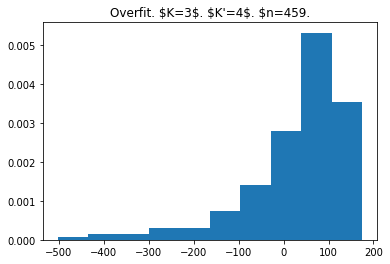

100%|██████████| 200/200 [00:10<00:00, 19.75it/s]


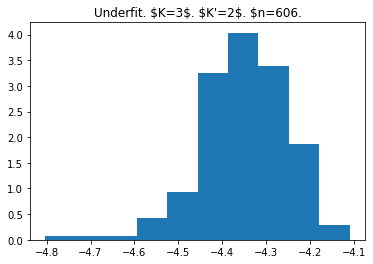

100%|██████████| 200/200 [00:26<00:00,  7.50it/s]


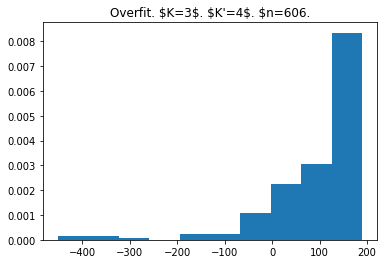

100%|██████████| 200/200 [00:11<00:00, 16.88it/s]


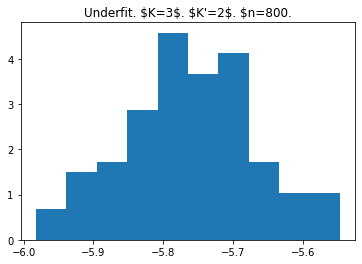

100%|██████████| 200/200 [00:33<00:00,  5.97it/s]


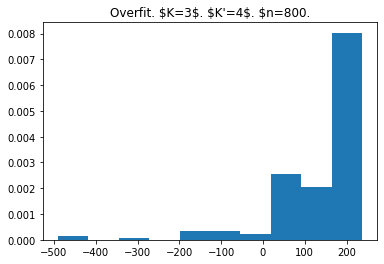

100%|██████████| 6/6 [03:37<00:00, 36.31s/it]


In [ ]:
n_list = np.array([round(x) for x in 200 * 2**np.linspace(0, 2, 6)])
record_list = []
for n in tqdm(n_list):
    record = {'n': n}
    n_true = np.array([round(n / K0)] * K0)
    n_true[-1] = n - n_true[:-1].sum()
    network = [generate_SBM(P_true=P_true, n_true=n_true, seed=i) for i in tqdm(range(200))]
    logLik_true = np.array([logLik_general_SBM(A=A, K=K0, labels=[list(range(n_true[:j].sum(), n_true[:(j+1)].sum())) for j in range(K0)], P=P_true)['logLik'] for A in tqdm(network)])
    record['logLik_true'] = logLik_true
    logLik_underfit = np.array([max_likelihood_estimator_kmeans(A, K0-1) for A in tqdm(network)])
    record['logLik_underfit'] = logLik_underfit
    plt.hist((logLik_underfit - logLik_true)/ n, density = True)
    plt.title(rf"Underfit. $K={K0}$. $K'={K0-1}$. $n={n}.")
    plt.show()
    logLik_overfit = np.array([max_likelihood_estimator_kmeans(A, K0+1) for A in tqdm(network)])
    record['logLik_overfit'] = logLik_overfit
    plt.hist((logLik_overfit - logLik_true) * 2, density = True)
    plt.title(rf"Overfit. $K={K0}$. $K'={K0+1}$. $n={n}.")
    plt.show()
    record_list.append(record)


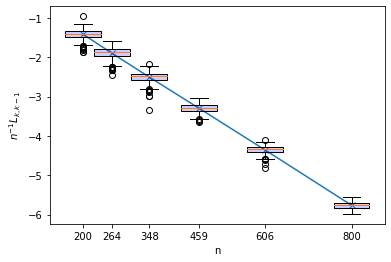

In [ ]:
for record in record_list:
    bp = plt.boxplot((record['logLik_underfit'] - record['logLik_true'])/record['n'], positions=[record['n']], widths=80, patch_artist=True, boxprops={'facecolor': (0,0,1,0.2)})
logLik_ratio_underfit_mean_list = [np.nanmean(record['logLik_underfit'] - record['logLik_true'])/record['n'] for record in record_list]
plt.plot(n_list, logLik_ratio_underfit_mean_list, 'x-')
plt.ylabel(r'$n^{-1}L_{k,k-1}$')
plt.xlabel('n')
plt.show()

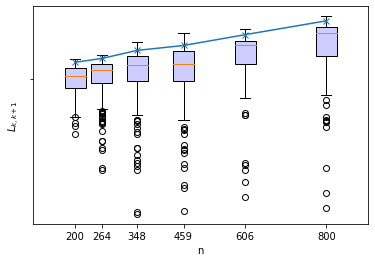

In [29]:
for record in record_list:
    bp = plt.boxplot((record['logLik_overfit'] - record['logLik_true']), positions=[record['n']], widths=50, patch_artist=True, boxprops={'facecolor': (0,0,1,0.2)})
logLik_ratio_overfit_95th_list = [np.nanquantile(record['logLik_overfit'] - record['logLik_true'], 0.95) for record in record_list]
plt.plot(n_list, logLik_ratio_overfit_95th_list, 'x-', '')
plt.ylabel(r'$L_{k,k+1}$')
plt.xlabel('n')
plt.xlim((100,900))
plt.show()

# If $K=1$

In [9]:
K0 = 1
n = 500
P_true = 0.03
n_true = n

In [10]:
network = [generate_SBM(P_true=P_true, n_true=n_true, seed=i) for i in tqdm(range(200))]

100%|██████████| 200/200 [00:01<00:00, 109.10it/s]


In [11]:
logLik_true = np.array([logLik_general_SBM(A=A, K=K0, P=P_true)['logLik'] for A in tqdm(network)])

100%|██████████| 200/200 [00:00<00:00, 8398.77it/s]


## Correct $K'=K$

100%|██████████| 200/200 [00:18<00:00, 10.56it/s]


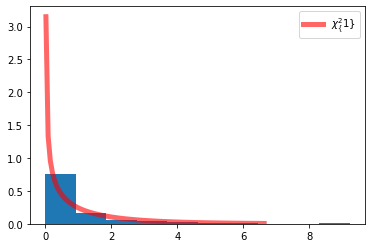

In [12]:
logLik_correct_K = np.array([max_likelihood_estimator_kmeans(A, K0) for A in tqdm(network)])
plt.hist((logLik_correct_K - logLik_true) * 2, density=True)
df = int(K0 * (K0+1) / 2)
x = np.linspace(chi2.ppf(0.1, df),
                chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=r'$\chi^2_\{' + str(df) +  r'\}$')
plt.legend()
plt.show()

This should be $\chi^2_1$

## Overfit $K'=K+1$

100%|██████████| 200/200 [00:18<00:00, 10.58it/s]


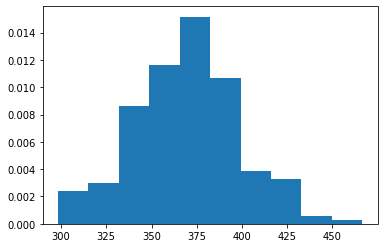

In [13]:
logLik_overfit = np.array([max_likelihood_estimator_kmeans(A, K0+1) for A in tqdm(network)])
plt.hist((logLik_overfit - logLik_true) * 2, density = True)
plt.show()

# If $K=2$

In [14]:
K0 = 2
n = 500
P_true = np.ones((K0, K0)) * 0.03 + np.eye(K0) * 0.15
n_true = np.array([round(n / K0)] * K0)
n_true[-1] = n - n_true[:-1].sum()

In [15]:
network = [generate_SBM(P_true=P_true, n_true=n_true, seed=i) for i in tqdm(range(200))]

100%|██████████| 200/200 [00:03<00:00, 57.98it/s]


In [16]:
logLik_true = np.array([logLik_general_SBM(A=A, K=K0, labels=[list(range(n_true[:j].sum(), n_true[:(j+1)].sum())) for j in range(K0)], P=P_true)['logLik'] for A in tqdm(network)])

100%|██████████| 200/200 [00:00<00:00, 322.40it/s]


## Underfit $K'=K-1$

100%|██████████| 200/200 [00:18<00:00, 10.58it/s]


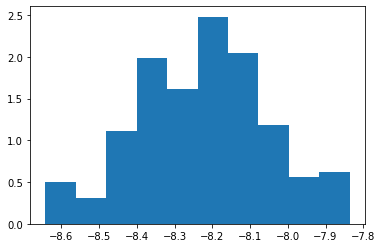

In [17]:
logLik_underfit = np.array([max_likelihood_estimator_kmeans(A, K0-1) for A in tqdm(network)])
plt.hist((logLik_underfit - logLik_true)/ n, density = True)
plt.show()

## Correct $K'=K$

100%|██████████| 200/200 [00:07<00:00, 26.98it/s]


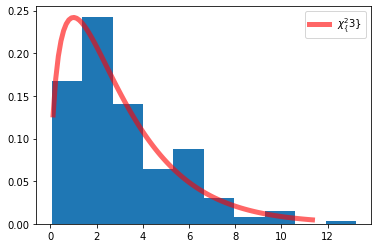

In [18]:
logLik_correct_K = np.array([max_likelihood_estimator_kmeans(A, K0) for A in tqdm(network)])
plt.hist((logLik_correct_K - logLik_true) * 2, density = True)
df = int(K0 * (K0+1) / 2)
x = np.linspace(chi2.ppf(0.01, df),
                chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=r'$\chi^2_\{' + str(df) +  r'\}$')
plt.legend()
plt.show()

## Overfit $K'=K+1$

100%|██████████| 200/200 [00:22<00:00,  9.08it/s]


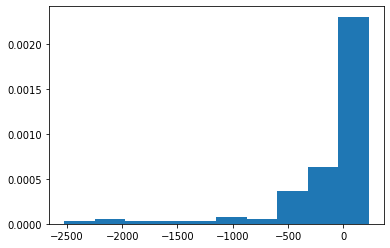

In [19]:
logLik_overfit = np.array([max_likelihood_estimator_kmeans(A, K0+1) for A in tqdm(network)])
plt.hist((logLik_overfit - logLik_true) * 2, density = True)
plt.show()

# If $K=4$

In [20]:
K0 = 4
n = 500
P_true = np.ones((K0, K0)) * 0.03 + np.eye(K0) * 0.15
n_true = np.array([round(n / K0)] * K0)
n_true[-1] = n - n_true[:-1].sum()

In [21]:
network = [generate_SBM(P_true=P_true, n_true=n_true, seed=i) for i in tqdm(range(200))]

100%|██████████| 200/200 [00:03<00:00, 60.98it/s]


In [22]:
logLik_true = np.array([logLik_general_SBM(A=A, K=K0, labels=[list(range(n_true[:j].sum(), n_true[:(j+1)].sum())) for j in range(K0)], P=P_true)['logLik'] for A in tqdm(network)])

100%|██████████| 200/200 [00:01<00:00, 118.44it/s]


## Underfit $K'=K-1$

100%|██████████| 200/200 [00:12<00:00, 16.54it/s]


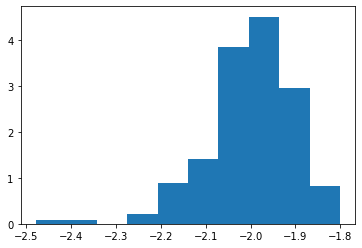

In [23]:
logLik_underfit = np.array([max_likelihood_estimator_kmeans(A, K0-1) for A in tqdm(network)])
plt.hist((logLik_underfit - logLik_true)/ n, density = True)
plt.show()

## Correct $K'=K$

100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


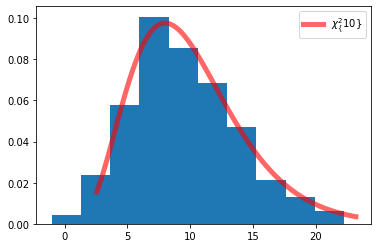

In [24]:
logLik_correct_K = np.array([max_likelihood_estimator_kmeans(A, K0) for A in tqdm(network)])
plt.hist((logLik_correct_K - logLik_true) * 2, density = True)
df = int(K0 * (K0+1) / 2)
x = np.linspace(chi2.ppf(0.01, df),
                chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=r'$\chi^2_\{' + str(df) +  r'\}$')
plt.legend()
plt.show()

## Overfit $K'=K+1$

100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


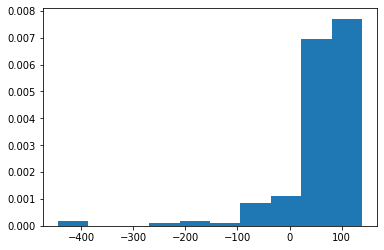

In [25]:
logLik_overfit = np.array([max_likelihood_estimator_kmeans(A, K0+1) for A in tqdm(network)])
plt.hist((logLik_overfit - logLik_true) * 2, density = True)
plt.show()

# Conclusion

- Underfitting case, $L_{K,K-1}<0$  and $|L_{K,K-1}|$ is of order $\Omega(n^2\rho_n)$. 
- Match case, $L_{K,K} \sim \chi^2_{K(K+1)/2}$, which is of order $1$. (Assuming $K$ fixed).
- Match case, $L_{K,K+1} \leq \alpha n \log K (1 + o_P(1))$, which is of order $n$. (We have also seen this in previous experiments).